# How to read in, visualize and analyze SIF data
Please see http://geo.holoviews.org/user_guide/Gridded_Datasets_I.html for background. A proper python installation is needed and some tools will need to be installed. 

required packages
nc-time-axis
dask 2.4
xarray
netcdf4
matplotlib
numpy
pandas

In [1]:
# https://scitools.org.uk/iris/docs/latest/index.html (data vis tool)
#import iris 
# Make sure plots are create inline
%matplotlib inline
import netCDF4
import matplotlib.pyplot as plt
# numpy 
import numpy as np
import pandas as pd
import dask
# xarray (very handy)
import xarray as xr
# specific for the tools here 
# http://geo.holoviews.org/index.html
#import holoviews as hv
#import geoviews as gv
#import geoviews.feature as gf
#import warnings
#gv.extension('bokeh')

In [2]:
xr.__version__, dask.__version__

('0.14.0', '2.4.0')

In [3]:
rainy_bbox = np.array([
    [-71.19583431678012,-13.861261028444734],
    [-69.29519955115512,-13.861261028444734],
    [-69.29519955115512,-12.384786628185896],
    [-71.19583431678012,-12.384786628185896],
    [-71.19583431678012,-13.861261028444734]])
max_lon_lat = np.max(rainy_bbox, axis=0)
min_lon_lat = np.min(rainy_bbox, axis=0)

In [4]:
dry_bbox = np.array([
    [-73.59634701209262,-15.105783159621957],
    [-71.69571224646762,-15.105783159621957],
    [-71.69571224646762,-13.551731041539325],
    [-73.59634701209262,-13.551731041539325],
    [-73.59634701209262,-15.105783159621957]])
dry_max_lon_lat = np.max(dry_bbox, axis=0)
dry_min_lon_lat = np.min(dry_bbox, axis=0)

### filter by bounding box

In [5]:
import xarray as xr

f = xr.open_dataset('../data/TROPO_SIF_03-2018.nc')

print(f['lat'].values[:5])  # [52.771 52.471 52.171 51.871 51.571 51.271 50.971]
print(f['lon'].values[:5]) # [3.927 4.227 4.527 4.827 5.127 5.427 5.727]

rainy_xds = f.sel(lon=slice(min_lon_lat[0], max_lon_lat[0]), lat=slice(min_lon_lat[1], max_lon_lat[1]))  
dry_xds = f.sel(lon=slice(dry_min_lon_lat[0], dry_max_lon_lat[0]), lat=slice(dry_min_lon_lat[1], dry_max_lon_lat[1]))  

[-89.9 -89.7 -89.5 -89.3 -89.1]
[-179.9 -179.7 -179.5 -179.3 -179.1]


In [6]:
rainy_xds.dcSIF

<xarray.DataArray 'dcSIF' (time: 31, lat: 7, lon: 10)>
array([[[    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan],
        ...,
        [    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan]],

       [[    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan],
        ...,
        [    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan]],

       ...,

       [[    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan],
        ...,
        [    nan,     nan, ...,  0.3852,     nan],
        [    nan,     nan, ...,  0.3155,  0.4633]],

       [[ 0.2411,  0.0322, ...,     nan,     nan],
        [-0.1583,     nan, ...,     nan,     nan],
        ...,
        [    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -

(array([  3.,  15., 149., 385., 330., 123.,  26.,   4.,   1.,   2.]),
 array([-0.38949999, -0.25169999, -0.11389999,  0.02390001,  0.1617    ,
         0.2995    ,  0.4373    ,  0.5751    ,  0.7129    ,  0.8507    ,
         0.9885    ]),
 <a list of 10 Patch objects>)

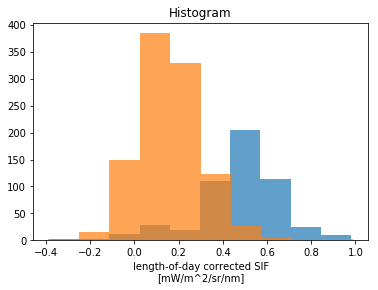

In [7]:
rainy_xds.dcSIF.plot(alpha=.7)
dry_xds.dcSIF.plot(alpha=.7)

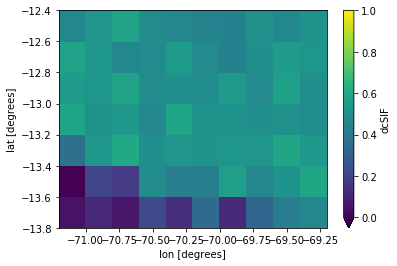

In [8]:
rainy_xds.dcSIF.mean(dim='time').plot(vmin=0, vmax=1)

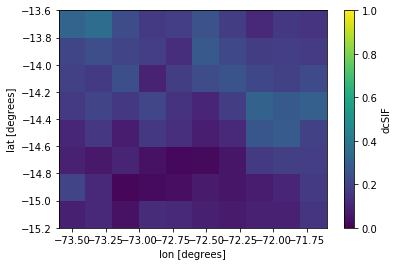

In [9]:
dry_xds.dcSIF.mean(dim='time').plot(vmin=0, vmax=1)

/Users/clifgray/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


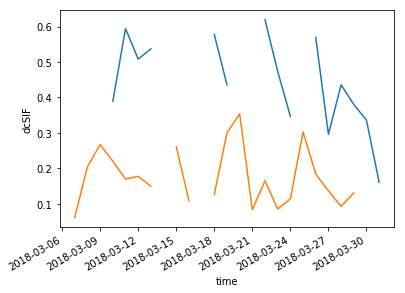

In [10]:
rainy_xds.dcSIF.mean(dim=('lat', 'lon')).plot()
dry_xds.dcSIF.mean(dim=('lat', 'lon')).plot()

### filter by time

In [11]:
rainy_xds.sel(time=slice("2018-03-01", "2018-03-010"))
dry_xds.sel(time=slice("2018-03-01", "2018-03-010"))

<xarray.Dataset>
Dimensions:     (lat: 8, lon: 10, time: 10)
Coordinates:
  * lon         (lon) float64 -73.5 -73.3 -73.1 -72.9 ... -72.1 -71.9 -71.7
  * lat         (lat) float64 -15.1 -14.9 -14.7 -14.5 -14.3 -14.1 -13.9 -13.7
  * time        (time) datetime64[ns] 2018-03-01 2018-03-02 ... 2018-03-10
Data variables:
    SIF         (time, lat, lon) float32 ...
    dcSIF       (time, lat, lon) float32 nan nan nan nan ... 0.213 0.0964 0.1793
    relSIF      (time, lat, lon) float32 ...
    SIF_err     (time, lat, lon) float32 ...
    dcSIF_err   (time, lat, lon) float32 ...
    relSIF_err  (time, lat, lon) float32 ...
    cont        (time, lat, lon) float32 ...
    n_meas      (time, lat, lon) float64 ...

### build accumulation datasets

In [64]:
# READ in all IMERG data together
imerg_xds = xr.open_mfdataset('../data/3B-DAY.MS.MRG.3IMERG.201803*.nc4')
imerg_xds

/Users/clifgray/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/Users/clifgray/anaconda3/lib/python3.6/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.Dataset>
Dimensions:                    (lat: 551, lon: 550, nv: 2, time: 8)
Coordinates:
  * nv                         (nv) float32 0.0 1.0
  * lat                        (lat) float32 -35.05 -34.95 ... 19.850002 19.95
  * lon                        (lon) float32 -84.95 -84.85 ... -30.049992
  * time                       (time) object 2018-03-01 00:00:00 ... 2018-03-12 00:00:00
Data variables:
    precipitationCal           (time, lon, lat) float32 dask.array<chunksize=(1, 550, 551), meta=np.ndarray>
    HQprecipitation            (time, lon, lat) float32 dask.array<chunksize=(1, 550, 551), meta=np.ndarray>
    precipitationCal_cnt       (time, lon, lat) int16 dask.array<chunksize=(1, 550, 551), meta=np.ndarray>
    randomError                (time, lon, lat) float32 dask.array<chunksize=(1, 550, 551), meta=np.ndarray>
    randomError_cnt            (time, lon, lat) int16 dask.array<chunksize=(1, 550, 551), meta=np.ndarray>
    time_bnds                  (time, nv) object da

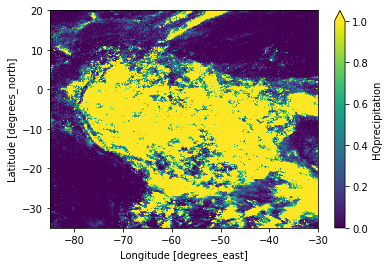

In [65]:
imerg_xds.HQprecipitation.mean(dim='time').plot(x="lon", y="lat", vmin=0, vmax=1)

In [66]:
rainy_imerg_xds = imerg_xds.sel(lon=slice(min_lon_lat[0], max_lon_lat[0]), lat=slice(min_lon_lat[1], max_lon_lat[1]))  
dry_imerg_xds = imerg_xds.sel(lon=slice(dry_min_lon_lat[0], dry_max_lon_lat[0]), lat=slice(dry_min_lon_lat[1], dry_max_lon_lat[1]))  

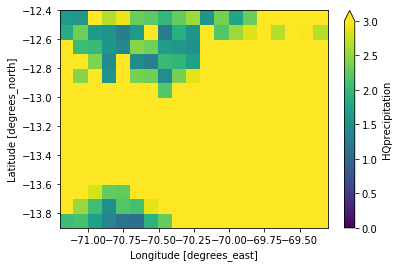

In [67]:
rainy_imerg_xds.HQprecipitation.mean(dim='time').plot(x="lon", y="lat", vmin=0, vmax=3)

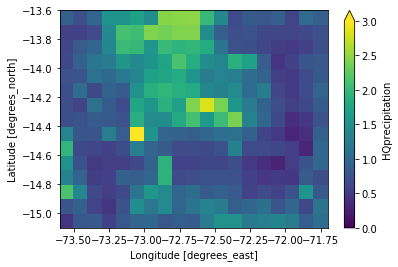

In [68]:
dry_imerg_xds.HQprecipitation.mean(dim='time').plot(x="lon", y="lat", vmin=0, vmax=3)

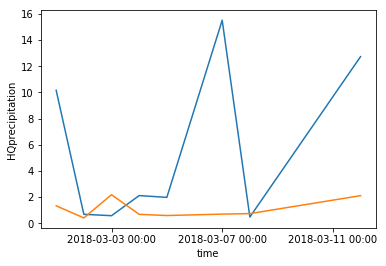

In [69]:
rainy_imerg_xds.HQprecipitation.mean(dim=('lat', 'lon')).plot()
dry_imerg_xds.HQprecipitation.mean(dim=('lat', 'lon')).plot()

#### create a rolling sum of a value through time

/Users/clifgray/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


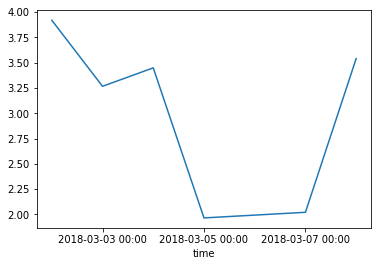

In [70]:
#rainy_imerg_xds.HQprecipitation.rolling(time=3, center=True).sum().mean(dim=('lat', 'lon')).plot()
# only filtering because we don't have the full IMERG dataset
#dry_xds.sel(time=slice("2018-03-01", "2018-03-010")).dcSIF.mean(dim=('lat', 'lon')).plot()
dry_imerg_xds.HQprecipitation.rolling(time=3, center=True).sum().mean(dim=('lat', 'lon')).plot()

/Users/clifgray/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


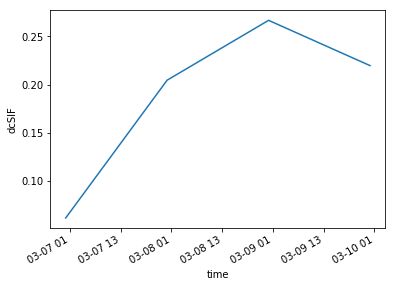

In [71]:
dry_xds.sel(time=slice("2018-03-05", "2018-03-10")).dcSIF.mean(dim=('lat', 'lon')).plot()

### comparing accumulated totals of rainfall to SIF values

In [ ]:
resample SIF to precip grid or vice versa



In [117]:
combo = xr.combine_by_coords([rainy_imerg_xds, rainy_xds], coords=['lat', 'lon'], join="right").dcSIF

In [118]:
combo

<xarray.DataArray 'dcSIF' (time: 31, lat: 7, lon: 10)>
array([[[    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan],
        ...,
        [    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan]],

       [[    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan],
        ...,
        [    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan]],

       ...,

       [[    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan],
        ...,
        [    nan,     nan, ...,  0.3852,     nan],
        [    nan,     nan, ...,  0.3155,  0.4633]],

       [[ 0.2411,  0.0322, ...,     nan,     nan],
        [-0.1583,     nan, ...,     nan,     nan],
        ...,
        [    nan,     nan, ...,     nan,     nan],
        [    nan,     nan, ...,     nan,     nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -

(array([  2.,   3.,  12.,  29.,  19., 110., 204., 114.,  25.,   9.]),
 array([-0.3872    , -0.25043   , -0.11366   ,  0.02311   ,  0.15987999,
         0.29664999,  0.43341999,  0.57018999,  0.70695999,  0.84372998,
         0.98049998]),
 <a list of 10 Patch objects>)

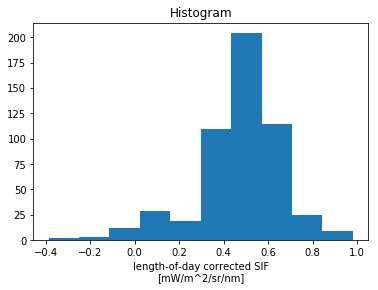

In [119]:
combo.plot()